In [577]:
#import libraries

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import os

import talib as ta
import sklearn
import seaborn as sns

import time
from sklearn import preprocessing, tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from feature_selector import FeatureSelector

from sklearn.cluster import KMeans

In [390]:
# Read SPDR S&P 500 (SPY) stock data from submission 1
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
spy = pd.read_csv('./stockdata/SPY_sub1.csv', 
                  usecols=['Date','Adj Close','Volume','Log Returns','SMA_50','EMA_50','EMA_200'],
                  parse_dates=['Date'], date_parser=dateparse)
spy.head()

,Date,Adj Close,Volume,Log Returns,SMA_50,EMA_50,EMA_200
0,2015-01-02,186.159332,121465900,NaN,NaN,NaN,NaN
1,2015-01-05,182.797379,169632600,-0.018225,NaN,NaN,NaN
2,2015-01-06,181.075607,209151400,-0.009464,NaN,NaN,NaN
3,2015-01-07,183.332016,125346700,0.012384,NaN,NaN,NaN
4,2015-01-08,186.585236,147217800,0.017589,NaN,NaN,NaN


In [391]:
# Feature Engineering

#get submission 1 data
spy_data = spy.copy()

# Add Features (i.e explainatory variables)

# 1.	Moving Average Convergence Divergence (MACD)
spy_data['MACD'],spy_data['MACD_Signal'],spy_data['MACD_Hist'] = ta.MACD(
    spy_data['Adj Close'], fastperiod=12, slowperiod=26,signalperiod=9) 


# 2.	Relative Strength Index (RSI)
spy_data['RSI'] = ta.RSI(spy_data['Adj Close'], timeperiod=14)


# 3.	On-Balance Volume (OBV)
spy_data['OBV'] = ta.OBV(spy_data['Adj Close'], spy_data['Volume'])


# 4.	Bollinger Bands
spy_data['upper_BBand'],spy_data['middle_BBand'],spy_data['lower_BBand'] = ta.BBANDS(
    spy_data['Adj Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
                                                                                  

# 5.	Target variable:
# If tomorrow’s close price goes up than today's close price then set to 1 (buy stock),
# otherwise set to -1 (sell stock). 
spy_data['Target'] = np.where(spy_data['Adj Close'].shift(-1) > spy_data['Adj Close'], 1, -1)


In [392]:
spy_data.head()

,Date,Adj Close,Volume,Log Returns,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Hist,RSI,OBV,upper_BBand,middle_BBand,lower_BBand,Target
0,2015-01-02,186.159332,121465900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121465900.0,NaN,NaN,NaN,-1
1,2015-01-05,182.797379,169632600,-0.018225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-48166700.0,NaN,NaN,NaN,-1
2,2015-01-06,181.075607,209151400,-0.009464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-257318100.0,NaN,NaN,NaN,1
3,2015-01-07,183.332016,125346700,0.012384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-131971400.0,NaN,NaN,NaN,1
4,2015-01-08,186.585236,147217800,0.017589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15246400.0,188.1651,183.989914,179.814728,-1


In [404]:
# Data Prepocessing

# 1. Log Transform
spy_data[['Adj Close','Volume','Log Returns','SMA_50','EMA_50','EMA_200','MACD',
          'MACD_Signal','MACD_Hist','RSI','OBV','upper_BBand','middle_BBand','lower_BBand']] = (
    spy_data[['Adj Close','Volume','Log Returns','SMA_50','EMA_50','EMA_200','MACD',
              'MACD_Signal','MACD_Hist','RSI','OBV','upper_BBand','middle_BBand',
              'lower_BBand']] - 
 spy_data[['Adj Close','Volume','Log Returns','SMA_50','EMA_50','EMA_200','MACD','MACD_Signal',
           'MACD_Hist','RSI','OBV','upper_BBand','middle_BBand','lower_BBand']].min()+
    1).transform(np.log)

spy_data.sample(3)

,Date,Adj Close,Volume,Log Returns,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Hist,RSI,OBV,upper_BBand,middle_BBand,lower_BBand,Target
513,2017-01-17,0.945021,1.365914,0.037294,0.913803,0.914432,0.857259,0.781434,0.760378,0.609281,0.937546,1.411230,0.938842,0.941965,0.950378,1
1087,2019-04-30,1.014552,1.371287,0.040879,1.003165,1.002912,0.991747,0.804538,0.784836,0.624693,0.963267,1.421087,1.012648,1.012997,1.015004,-1
141,2015-07-27,0.874457,1.379320,0.035231,0.831250,0.822331,NaN,0.762489,0.734894,0.613780,0.891909,1.414109,0.882535,0.876845,0.885663,1


In [394]:
# Data Prepocessing

# 2.  Imputation

# Examine which features have NaNs (Not a number)
percent_missing = spy_data.isnull().sum() * 100 / len(spy_data)
missing_values = pd.DataFrame({'NaNs percentage': percent_missing})
missing_values.sort_values(by ='NaNs percentage' , ascending=False)

,NaNs percentage
EMA_200,15.831344
SMA_50,3.898170
EMA_50,3.898170
MACD,2.625298
MACD_Signal,2.625298
MACD_Hist,2.625298
RSI,1.113763
upper_BBand,0.318218
middle_BBand,0.318218
lower_BBand,0.318218


In [395]:
# Set up a threshold of 15%, and delete rows that have more than the threshold
spy_trim = spy_data.loc[:, spy_data.isnull().sum() < 0.15 * spy_data.shape[0]]

# Check results of deletions of exccessive NaNs
percent_missing = spy_trim.isnull().sum() * 100 / len(spy_trim)
missing_values = pd.DataFrame({'NaNs percentage': percent_missing})
missing_values.sort_values(by ='NaNs percentage' , ascending=False)

,NaNs percentage
SMA_50,3.898170
EMA_50,3.898170
MACD,2.625298
MACD_Signal,2.625298
MACD_Hist,2.625298
RSI,1.113763
upper_BBand,0.318218
middle_BBand,0.318218
lower_BBand,0.318218
Log Returns,0.079554


In [396]:
# Replace all NaN with column median
spy_trim['EMA_50'].fillna(spy_trim['EMA_50'].median(), inplace=True)
spy_trim['SMA_50'].fillna(spy_trim['SMA_50'].median(), inplace=True)
spy_trim['MACD_Signal'].fillna(spy_trim['MACD_Signal'].median(), inplace=True)
spy_trim['MACD_Hist'].fillna(spy_trim['MACD_Hist'].median(), inplace=True)
spy_trim['MACD'].fillna(spy_trim['MACD'].median(), inplace=True)
spy_trim['RSI'].fillna(spy_trim['RSI'].median(), inplace=True)
spy_trim['lower_BBand'].fillna(spy_trim['lower_BBand'].median(), inplace=True)
spy_trim['middle_BBand'].fillna(spy_trim['middle_BBand'].median(), inplace=True)
spy_trim['upper_BBand'].fillna(spy_trim['upper_BBand'].median(), inplace=True)
spy_trim['Log Returns'].fillna(spy_trim['Log Returns'].median(), inplace=True)

# Check results of imputation using column medians
percent_missing = spy_trim.isnull().sum() * 100 / len(spy_trim)
missing_values = pd.DataFrame({'NaNs percentage': percent_missing})
missing_values.sort_values(by ='NaNs percentage' , ascending=False)

,NaNs percentage
Date,0.0
Adj Close,0.0
Volume,0.0
Log Returns,0.0
SMA_50,0.0
EMA_50,0.0
MACD,0.0
MACD_Signal,0.0
MACD_Hist,0.0
RSI,0.0


In [397]:
# 3. Dealing with Dates

# Split Date column into three: Year, Month, Day
spy_trim['Year'] = spy_trim['Date'].dt.year
spy_trim['Month'] = spy_trim['Date'].dt.month
spy_trim['Day'] = spy_trim['Date'].dt.day
spy_trim.drop(['Date'],axis = 1, inplace=True)
spy_trim.head()

,Adj Close,Volume,Log Returns,SMA_50,EMA_50,MACD,MACD_Signal,MACD_Hist,RSI,OBV,upper_BBand,middle_BBand,lower_BBand,Target,Year,Month,Day
0,2.892223,18.432569,0.042601,4.006247,3.993246,2.24093,2.05534,1.374663,3.730973,21.926262,4.104096,4.119029,4.179709,-1,2015,1,2
1,2.685900,18.821887,0.024492,4.006247,3.993246,2.24093,2.05534,1.374663,3.730973,21.873980,4.104096,4.119029,4.179709,-1,2015,1,5
2,2.561067,19.056630,0.033005,4.006247,3.993246,2.24093,2.05534,1.374663,3.730973,21.805511,4.104096,4.119029,4.179709,1,2015,1,6
3,2.721693,18.470201,0.053923,4.006247,3.993246,2.24093,2.05534,1.374663,3.730973,21.847105,4.104096,4.119029,4.179709,1,2015,1,7
4,2.915566,18.659287,0.058843,4.006247,3.993246,2.24093,2.05534,1.374663,3.730973,21.893846,2.751555,2.622624,2.713876,-1,2015,1,8


In [409]:
# 4. Handling Outliers

# Detect & Drop the outlier rows with Z-score
z = np.abs(stats.zscore(spy_trim))

prc_data = spy_trim[(z < 3).all(axis=1)]
prc_data.shape

(1165, 17)

In [410]:
# Reindex data and drop Date & other Index col
data = prc_data.copy()
data.reset_index(inplace=True)
data.drop(['index'], axis = 1, inplace=True)

In [689]:
# 5. Categorical Data Encoding

# Split dataset in features (X) and labels (Y) & apply label encoding to Y
X = data.drop(columns = 'Target')
y = data['Target']

y = LabelEncoder().fit_transform(y)

In [ ]:
# 6. Scaling features (X) using Standardization 
#scaler = StandardScaler()
#X = pd.DataFrame(scaler.fit_transform(X.to_numpy()), columns=X.columns, index=X.index)
#X.head()

In [700]:
# Feature Selection

# Features (X) and labels (y)
fs = FeatureSelector(data = X, labels = y)

# Find all features to remove
fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.8, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.8});

0 features with greater than 0.60 missing values.

0 features with a single unique value.

8 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.556189	valid_0's binary_logloss: 0.687405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.608117	valid_0's binary_logloss: 0.688261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.552911	valid_0's binary_logloss: 0.68998
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.542552	valid_0's binary_logloss: 0.688521
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.526357	valid_0's binary_logloss: 0.69058
Training until v

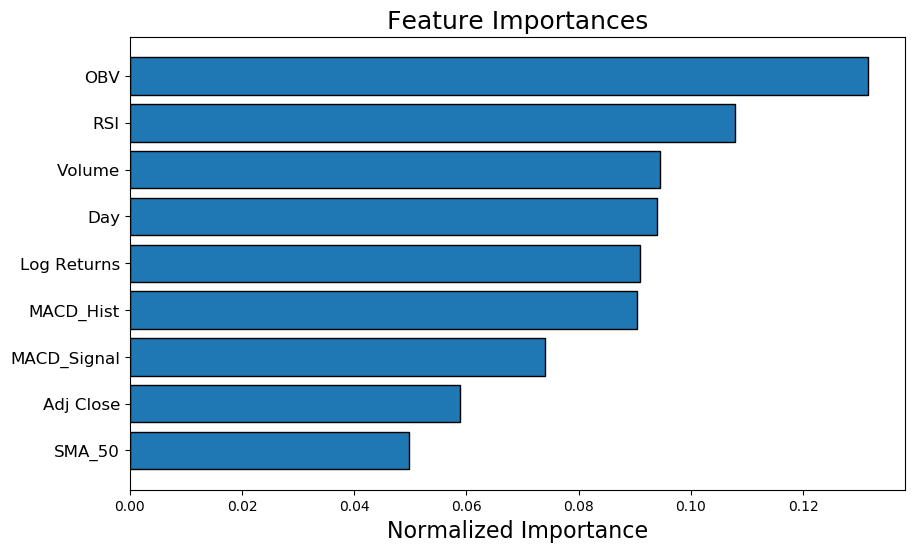

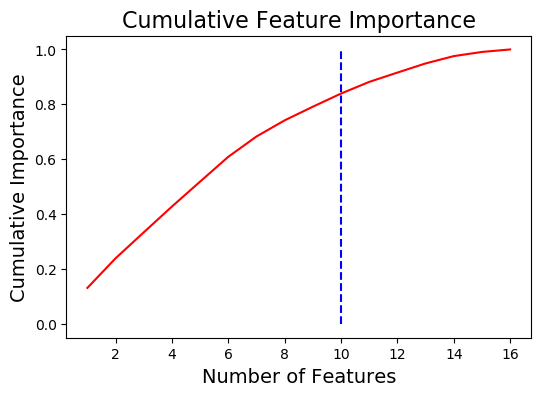

10 features required for 0.80 of cumulative importance


In [701]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.8, plot_n = 9)

In [702]:
fs.ops

{'missing': [],
 'single_unique': [],
 'collinear': ['SMA_50',
  'EMA_50',
  'MACD_Signal',
  'OBV',
  'upper_BBand',
  'middle_BBand',
  'lower_BBand',
  'Year'],
 'zero_importance': [],
 'low_importance': ['lower_BBand',
  'MACD',
  'Month',
  'upper_BBand',
  'EMA_50',
  'middle_BBand',
  'Year']}

In [703]:
fs_data = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 10 features.


In [706]:
fs_data.head()

,Adj Close,Volume,Log Returns,MACD_Hist,RSI,Day
0,2.892223,18.432569,0.042601,1.374663,3.730973,2
1,2.685900,18.821887,0.024492,1.374663,3.730973,5
2,2.561067,19.056630,0.033005,1.374663,3.730973,6
3,2.721693,18.470201,0.053923,1.374663,3.730973,7
4,2.915566,18.659287,0.058843,1.374663,3.730973,8


In [707]:
fs_data.corr()

,Adj Close,Volume,Log Returns,MACD_Hist,RSI,Day
Adj Close,1.000000,-0.528056,0.054787,0.086227,0.325489,0.029807
Volume,-0.528056,1.000000,-0.136786,-0.207403,-0.486805,-0.063902
Log Returns,0.054787,-0.136786,1.000000,0.110513,0.310790,-0.029786
MACD_Hist,0.086227,-0.207403,0.110513,1.000000,0.565515,0.038185
RSI,0.325489,-0.486805,0.310790,0.565515,1.000000,0.023254
Day,0.029807,-0.063902,-0.029786,0.038185,0.023254,1.000000


In [735]:
# Feature Extraction

# New features (X) and labels (y) after Feature Selection
X_fs = fs_data
y_fs = fs.labels

# Scaling features (X) using Standardization 
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_fs)

# Principle Components Analysis (PCA)
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_sc)
PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6'])
PCA_df = pd.concat([PCA_df, pd.DataFrame(data=y_fs, columns = ['Target'])], axis = 1)
PCA_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Target
0,1.147418,-1.667786,0.896306,-0.678522,-0.365147,-0.455389,0
1,2.308747,-0.757710,-0.104340,-2.724632,-0.368381,-1.251105,0
2,2.265929,-1.561677,-0.044900,-1.691991,-0.034718,-1.154353,1
3,0.812071,-2.435262,0.665007,0.865609,-0.254237,-0.165108,1
4,0.684309,-2.720377,0.731615,1.484920,0.250396,-0.135882,0


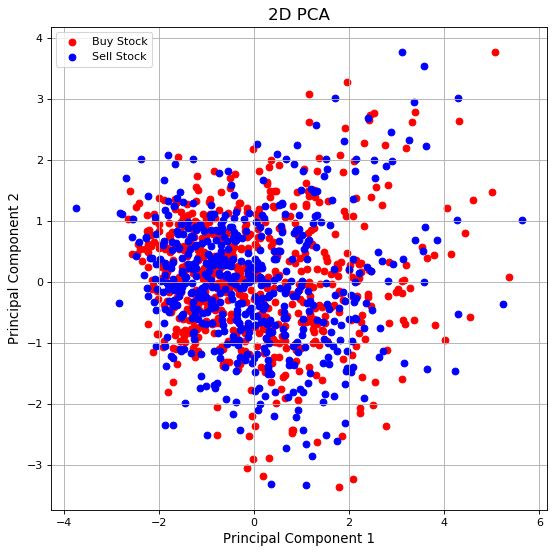

In [723]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

classes = [1, 0]
colors = ['r', 'b']
for clas, color in zip(classes, colors):
    plt.scatter(PCA_df.loc[PCA_df['Target'] == clas, 'PC1'], 
                PCA_df.loc[PCA_df['Target'] == clas, 'PC2'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('2D PCA', fontsize = 15)
plt.legend(['Buy Stock', 'Sell Stock'])
plt.grid()

In [736]:
pca.explained_variance_ratio_

array([0.36949176, 0.18525608, 0.16753544, 0.14797077, 0.07587335,
       0.0538726 ])

In [725]:
def forest_test(X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, 
                                                        random_state = 42)
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
    print(time.process_time() - start)
    predictionforest = trainedforest.predict(X_Test)
    print(confusion_matrix(Y_Test,predictionforest))
    print(classification_report(Y_Test,predictionforest))

In [726]:
forest_test(X_pca, y_fs)

3.921875
[[ 62  97]
 [ 82 109]]
              precision    recall  f1-score   support

           0       0.43      0.39      0.41       159
           1       0.53      0.57      0.55       191

    accuracy                           0.49       350
   macro avg       0.48      0.48      0.48       350
weighted avg       0.48      0.49      0.49       350

